# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/github/WilliamJWen/APS360/blob/main/lab/Lab3_Gesture_Recognition.ipynb

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
import random

import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/APS360/lab3

/content/drive/MyDrive/APS360/lab3


In [4]:
# globals
seed = 117
random.seed(seed)

torch.manual_seed(seed)

In [5]:
dataset_path = 'Lab3_Gestures_Summer'

# transformation process
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)

def get_prefix_num(filename):
  return int(filename.split("_")[0])
def get_suffix_num(filename):
  return int(filename.split("_")[-1].split(".")[0])

In [6]:
prefix_seen = set()
duplicate = False

for img_path, label in dataset.imgs:
  filename = os.path.basename(img_path)
  prefix_id = get_prefix_num(filename)
  if prefix_id in prefix_seen:
    duplicate = True
    break

if (duplicate):
  print("There is duplicate prefix id.")
else:
  print("All prefix id is unique confirmed")

All prefix id is unique confirmed


In [7]:
### put images into groups of same person and light

# store original indices
indexed_images = [(i, img_path, label) for i, (img_path, label) in enumerate(dataset.imgs)]
sorted_images = sorted(indexed_images, key=lambda x: get_prefix_num(os.path.basename(x[1])))

groups = []
current_group = []

for og_idx, img_path, label in sorted_images:
  filename = os.path.basename(img_path)
  prefix_id = get_prefix_num(filename)

  if not current_group:
    current_group.append(og_idx)
  else:
    prev_filename = os.path.basename(indexed_images[current_group[-1]][1])
    prev_prefix = get_prefix_num(prev_filename)

    # group sequential images into a group
    if prefix_id == prev_prefix + 1 and get_suffix_num(filename) == get_suffix_num(prev_filename) + 1:
      current_group.append(og_idx)
    else:
      # start a new group
      groups.append(current_group)
      current_group = [og_idx]

# append last group
if current_group:
  groups.append(current_group)

In [8]:
print(groups)

[[118, 172], [429, 442, 455], [707, 720, 736], [992, 758, 774], [1026, 1036, 1049], [1302, 1314, 1329], [1583, 1593, 1609], [1858, 1871, 1884], [2131, 2132, 2136], [166, 167, 171], [418, 419, 423], [666, 667, 670], [917, 918, 922], [1168, 1169, 1173], [1407, 1408, 1412], [1662, 1663, 1667], [1910, 1911, 1915], [2162, 2163, 2167], [200], [204], [232, 233, 237], [483, 484, 488], [730, 731, 735], [980, 981, 985], [1231, 1232, 1236], [1470, 1471, 1475], [1725, 1476, 1480], [1729, 1730, 1734], [1976, 1977, 1981], [11, 12, 16], [269, 270, 274], [517, 518, 522], [768, 769, 773], [1017, 1018, 1022], [1266, 1267, 1268], [1508, 1509, 1513], [1759, 1760, 1764], [2007, 2008, 2012], [44, 45, 49], [302], [547, 548, 552], [797, 798, 799], [1043, 1044, 1048], [1290, 1291, 1295], [1538, 1539, 1543], [1789, 1790, 1794], [2037, 2038, 2042], [74, 75, 79], [328, 329, 333], [577, 578, 582], [827, 828, 832], [1077, 1078, 1082], [1323, 1324, 1328], [1571, 1572, 1576], [1822, 1823, 1824], [2070, 2071, 2075], [

In [9]:
# randomly split into train, val and test
random.shuffle(groups)

train_ratio, val_ratio = 0.7, 0.15
num_groups = len(groups)
train_end = int(train_ratio * num_groups)
val_end = train_end + int(val_ratio * num_groups)

# split the groups
train_groups = groups[:train_end]
val_groups = groups[train_end:val_end]
test_groups = groups[val_end:]

In [10]:
# collect indices from groups
train_indices = [idx for group in train_groups for idx in group]
val_indices = [idx for group in val_groups for idx in group]
test_indices = [idx for group in test_groups for idx in group]


# Subset Datasets
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Testset size: {len(test_set)}")


Training set size: 1556
Validation set size: 333
Testset size: 330


Answer:
- I first put all images into groups of images that have the same hand and lightning condition. And shuffled and splited the groups into 70-15-15 ratio for test-validation and test respectively. And then unpack the groups to images to load.

- In this way, all images in validation and test would be hands that are not in test accuracy, so that they can accurately simulate model's performance when working with new data in real world.

- Also, this global random shuffle on groups would work, because we have a balanced dataset where each class has around 266 images and each group has almost exact three images.



### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [11]:
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torch.optim as optim

In [12]:
class GestNet(nn.Module):
  def __init__(self,
               model_version="",
               conv1_filters=32,
               conv2_filters=64,
               conv3_filters=128,
               fc1_units=64,
               dropout_rate=0.4):
    super(GestNet, self).__init__()
    self.name = "GestNet_" + model_version

    self.conv1 = nn.Conv2d(3, conv1_filters, 3, 1, 1)
    self.bn1 = nn.BatchNorm2d(conv1_filters) # Normalize each feature, batch_size won't change
    self.pool = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(conv2_filters)

    self.conv3 = nn.Conv2d(conv2_filters, conv3_filters, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(conv3_filters)

    # lobal Average Pooling (Average the whole feature into 1 * 1)
    self.gap = nn.AdaptiveAvgPool2d(1)  # Output shape = (batch, conv3_filters, 1, 1)

    # Fully Connected Layers
    self.fc1 = nn.Linear(conv3_filters, fc1_units)
    # Dropout
    self.dropout = nn.Dropout(dropout_rate)
    self.fc2 = nn.Linear(fc1_units, 9) # 9 is number of classes

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))

    x = self.gap(x)
    x = torch.flatten(x, 1) # flatten to (batch, conv3_filters)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x



In [14]:
model = GestNet()
print(model)

GestNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=9, bias=True)
)


Answer: I used 13 layers in total
- 3 convolutional layer with increasing number of filters (32 -> 64 -> 128): learn more higher-level features as we go deeper
- 3 batch normalization layers: stablize training
- 3 max pooling layers: reduce image size to capture larger feature
- 1 global average pooling layer: reduce parameters and flatten output, and make model invariant to input size (not important in this case)
- 2 fully connected layers: 1 hidden layer to make clasification more complex
- 1 dropout layer: prevent overfitting, parameter tunable.

For Activation function I used Relu, it has been shown to be  the most simple and effective Activation Function in lectures and Lab1.


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [13]:
import time

In [14]:
def train(model, train_data, val_data, batch_size=32, num_epochs=30, learning_rate = 0.001):
    torch.manual_seed(1000)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
      print("using cuda!")
      model.cuda()
    else:
      print("Cuda is not available")

    # DataLoder
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Lost function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Array to hold error and loss
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print("Training Started!")
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        for imgs, labels in iter(train_loader):

            if use_cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)                # forward pass
            loss = criterion(out, labels)    # compute the total loss
            loss.backward()                  # backward pass (compute parameter updates)
            optimizer.step()                 # make the updates for each parameter
            optimizer.zero_grad()            # a clean up step for PyTorch
            total_train_loss += loss.item()

        train_err[epoch] = get_error(model, train_loader)
        train_loss[epoch] = float(total_train_loss) / (len(train_loader))
        val_err[epoch] = get_error(model, val_loader)
        val_loss[epoch] = get_loss(model, val_loader, criterion)

        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later

    epochs = np.arange(1, num_epochs + 1)

    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    plot_training_curve(model_path)

def get_accuracy(model, data_loader):
    correct = 0
    total = 0

    for imgs, labels in data_loader:

        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

def get_error(model, data_loader):
    correct = 0
    total = 0
    eval_mod = model.eval()
    for imgs, labels in data_loader:

        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        out = eval_mod(imgs)
        #select index with maximum prediction score
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return (total-correct) / total

def get_loss(model, data_loader, criterion):
    loss = 0.0
    total_loss = 0.0
    eval_mod = model.eval()
    for imgs, labels in data_loader:

      if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

      out = eval_mod(imgs)
      loss = criterion(out, labels)
      total_loss += loss.item()

    loss = float(total_loss) / (len(data_loader))
    return loss


# Code from Lab 2 for plotting the training curve

def get_model_name(name, batch_size, learn_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learn_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

- Loss Function: Cross Entropy
- Optiizer: ADAM  

This is a multi-class classification problem, thus Cross Entropy is suitable for this. Adam should always be used is taugh in the lecture.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [17]:
# create small dataset
small_dataset_size = 20
indices = random.sample(range(len(dataset)), small_dataset_size)
small_train_data = Subset(dataset, indices)

using cuda!
Training Started!
Epoch 1: Train err: 0.8, Train loss: 2.1396496295928955 |Validation err: 0.8, Validation loss: 2.1810855865478516
Epoch 2: Train err: 0.75, Train loss: 2.1810853481292725 |Validation err: 0.75, Validation loss: 2.1675515174865723
Epoch 3: Train err: 0.75, Train loss: 2.1675515174865723 |Validation err: 0.75, Validation loss: 2.1500370502471924
Epoch 4: Train err: 0.75, Train loss: 2.1500368118286133 |Validation err: 0.75, Validation loss: 2.126976728439331
Epoch 5: Train err: 0.75, Train loss: 2.12697696685791 |Validation err: 0.75, Validation loss: 2.095841407775879
Epoch 6: Train err: 0.75, Train loss: 2.095841646194458 |Validation err: 0.75, Validation loss: 2.05706787109375
Epoch 7: Train err: 0.75, Train loss: 2.057068109512329 |Validation err: 0.75, Validation loss: 2.013267755508423
Epoch 8: Train err: 0.75, Train loss: 2.013267993927002 |Validation err: 0.75, Validation loss: 1.9716441631317139
Epoch 9: Train err: 0.75, Train loss: 1.97164416313171

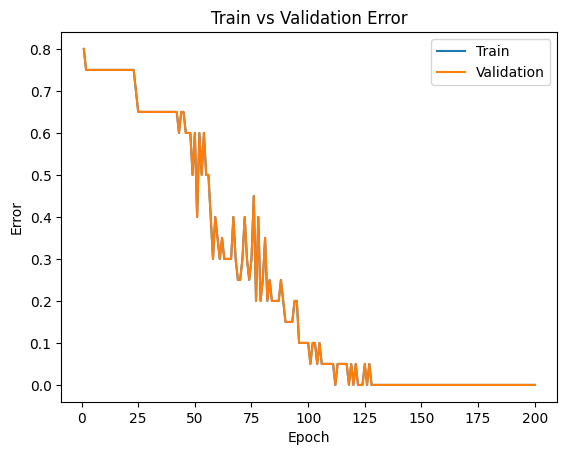

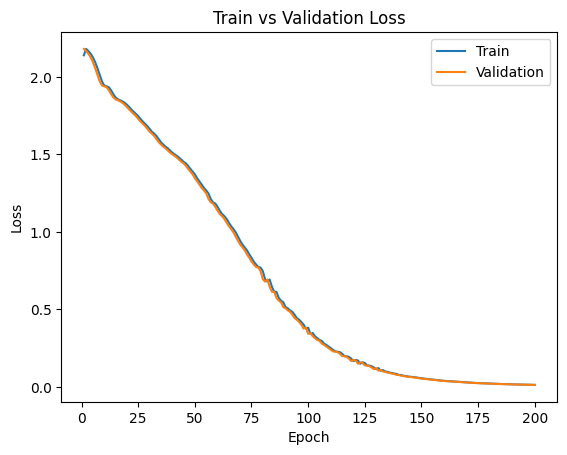

True

In [23]:
overfit_model = GestNet(model_version="overfit", dropout_rate=0)
train(overfit_model, small_train_data, small_train_data, num_epochs=200, batch_size=len(small_train_data), learning_rate=0.001)


### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

Answer:
- batch_size
- epoch_number
- number of convolution filters

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

using cuda!
Training Started!
Epoch 1: Train err: 0.852827763496144, Train loss: 2.202554021562849 |Validation err: 0.9219219219219219, Validation loss: 2.205189249732278
Epoch 2: Train err: 0.7802056555269923, Train loss: 2.1438916435047073 |Validation err: 0.9069069069069069, Validation loss: 2.1836207779971035
Epoch 3: Train err: 0.6921593830334191, Train loss: 1.8764034144732418 |Validation err: 0.8138138138138138, Validation loss: 1.9512603174556384
Epoch 4: Train err: 0.6805912596401028, Train loss: 1.7443678743985234 |Validation err: 0.7867867867867868, Validation loss: 1.8975294394926592
Epoch 5: Train err: 0.6658097686375322, Train loss: 1.6909935985292708 |Validation err: 0.8318318318318318, Validation loss: 1.8977252353321423
Epoch 6: Train err: 0.640745501285347, Train loss: 1.6502528628524469 |Validation err: 0.8348348348348348, Validation loss: 1.9117723053151912
Epoch 7: Train err: 0.6375321336760925, Train loss: 1.6008712272254788 |Validation err: 0.7507507507507507, Va

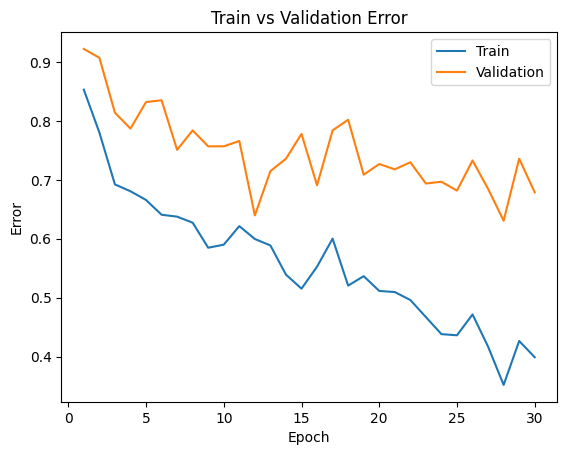

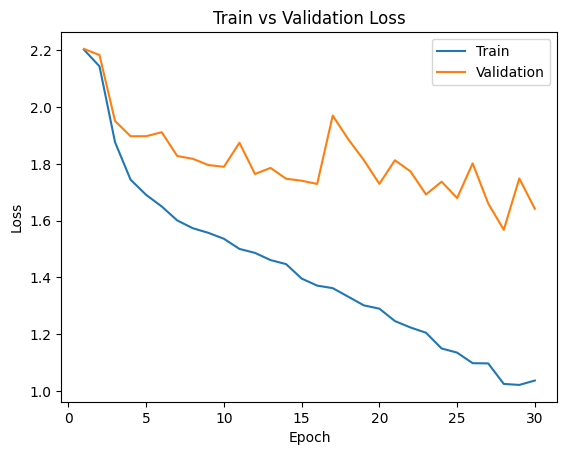

In [17]:
model_default = GestNet()
train(model_default, train_set, val_set)

using cuda!
Training Started!
Epoch 1: Train err: 0.8598971722365039, Train loss: 2.194014004298619 |Validation err: 0.93993993993994, Validation loss: 2.20660662651062
Epoch 2: Train err: 0.8534704370179949, Train loss: 2.193078245435442 |Validation err: 0.9279279279279279, Validation loss: 2.212997317314148
Epoch 3: Train err: 0.8444730077120822, Train loss: 2.1908325467790877 |Validation err: 0.924924924924925, Validation loss: 2.224554657936096
Epoch 4: Train err: 0.8521850899742931, Train loss: 2.186476639338902 |Validation err: 0.9069069069069069, Validation loss: 2.229960560798645
Epoch 5: Train err: 0.859254498714653, Train loss: 2.177542516163417 |Validation err: 0.9099099099099099, Validation loss: 2.223060727119446
Epoch 6: Train err: 0.8316195372750642, Train loss: 2.178091049194336 |Validation err: 0.8948948948948949, Validation loss: 2.2486056089401245
Epoch 7: Train err: 0.8598971722365039, Train loss: 2.1730121544429233 |Validation err: 0.9159159159159159, Validation lo

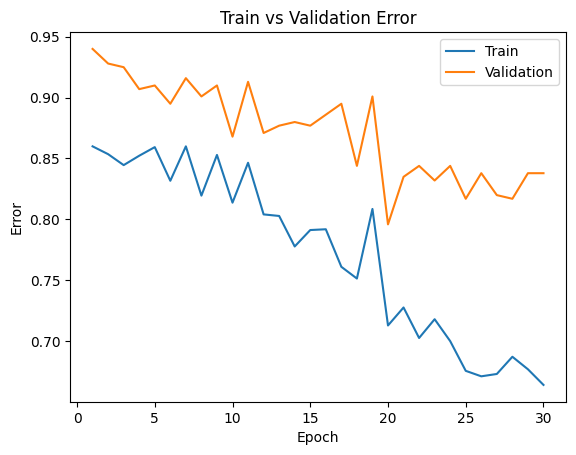

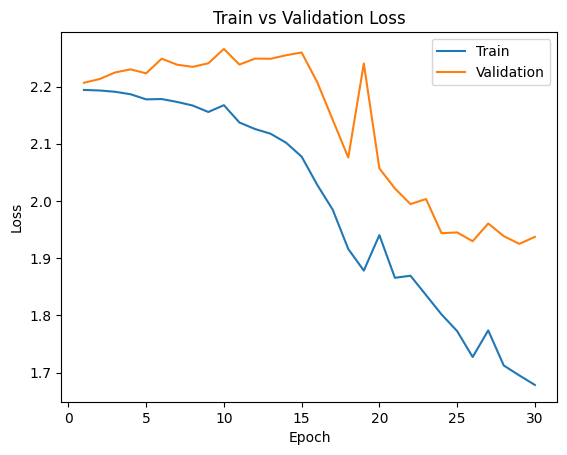

In [19]:
model_lg_batch = GestNet()
train(model_lg_batch, train_set, val_set, batch_size=256)

using cuda!
Training Started!
Epoch 1: Train err: 0.8123393316195373, Train loss: 2.1852488079849555 |Validation err: 0.8858858858858859, Validation loss: 2.191269419410012
Epoch 2: Train err: 0.7397172236503856, Train loss: 2.065277311266685 |Validation err: 0.8648648648648649, Validation loss: 2.0114627209576694
Epoch 3: Train err: 0.7712082262210797, Train loss: 1.8066038160907978 |Validation err: 0.8558558558558559, Validation loss: 2.037610509178855
Epoch 4: Train err: 0.647172236503856, Train loss: 1.739122276403466 |Validation err: 0.7777777777777778, Validation loss: 1.882610938765786
Epoch 5: Train err: 0.6503856041131105, Train loss: 1.6698190071144883 |Validation err: 0.8498498498498499, Validation loss: 1.893933122808283
Epoch 6: Train err: 0.6356041131105399, Train loss: 1.6365314186835775 |Validation err: 0.8408408408408409, Validation loss: 1.9145391529256648
Epoch 7: Train err: 0.6246786632390745, Train loss: 1.584172098004088 |Validation err: 0.7357357357357357, Valida

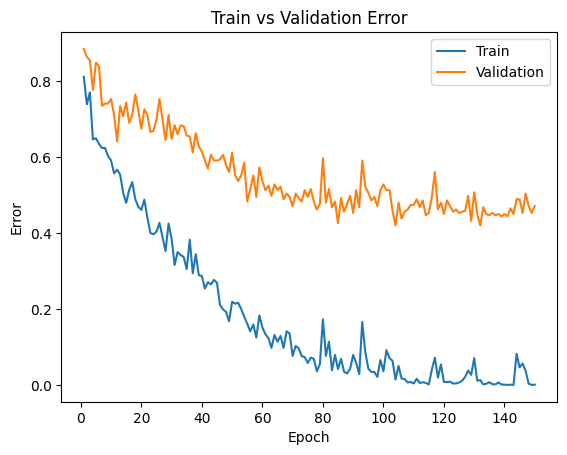

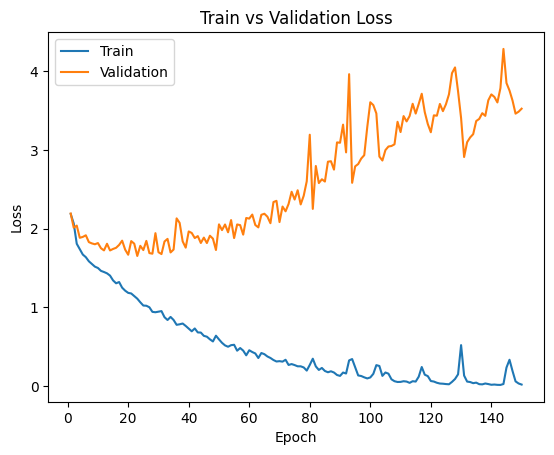

In [24]:
model_large_epoch = GestNet()
train(model_large_epoch, train_set, val_set, num_epochs=150)

using cuda!
Training Started!
Epoch 1: Train err: 0.8470437017994858, Train loss: 2.19132560613204 |Validation err: 0.9309309309309309, Validation loss: 2.235022089698098
Epoch 2: Train err: 0.8213367609254498, Train loss: 2.169203281402588 |Validation err: 0.8978978978978979, Validation loss: 2.239170703020963
Epoch 3: Train err: 0.7506426735218509, Train loss: 2.084550388005315 |Validation err: 0.8258258258258259, Validation loss: 2.0898442701859907
Epoch 4: Train err: 0.6625964010282777, Train loss: 1.851451348285286 |Validation err: 0.8108108108108109, Validation loss: 1.8617449348623103
Epoch 5: Train err: 0.7551413881748072, Train loss: 1.7513242400422389 |Validation err: 0.8588588588588588, Validation loss: 1.9889959422024814
Epoch 6: Train err: 0.6426735218508998, Train loss: 1.7036998101643153 |Validation err: 0.8288288288288288, Validation loss: 1.8378537459806963
Epoch 7: Train err: 0.6497429305912596, Train loss: 1.6282141038349696 |Validation err: 0.7867867867867868, Valid

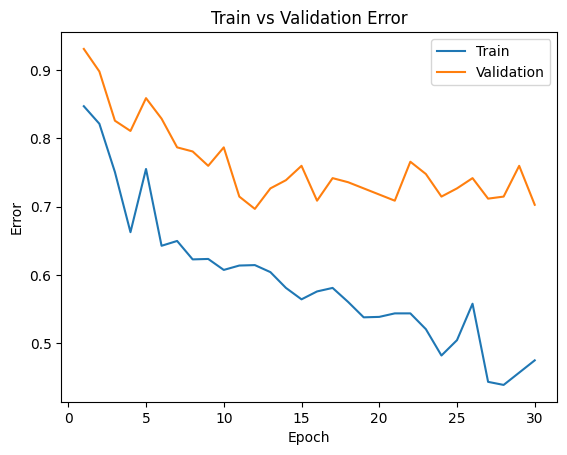

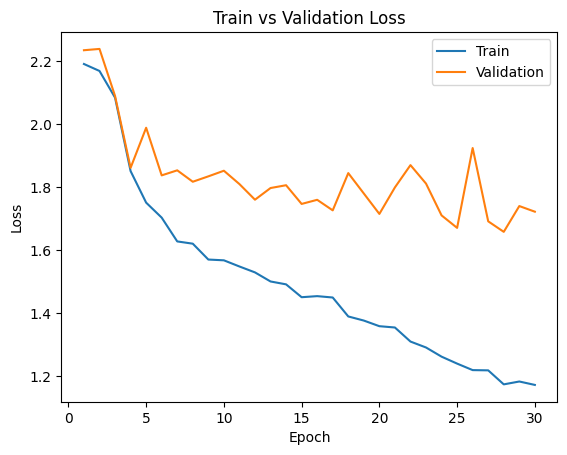

In [22]:
model_lg_batch = GestNet(model_version="cv16-32-64", conv1_filters=16, conv2_filters=32, conv3_filters=64)
train(model_lg_batch, train_set, val_set)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

Answer: The best trained model is model_default, because it has the smallest validation loss, and no sign of overfitting.



### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [31]:
def get_test_accuracy(model, test_loader):
    use_cuda = torch.cuda.is_available()

    # set to evaluation mode
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
      for imgs, labels in test_loader:

          # Enable GPU Usage
          if use_cuda:
            imgs, labels = imgs.cuda(), labels.cuda()

          output = model(imgs)

          # Select index with maximum prediction score
          pred = output.argmax(dim=1)
          correct += pred.eq(labels).sum().item()
          total += labels.size(0)

    return correct / total

In [33]:
test_accuracy = get_test_accuracy(model_default, test_loader)
print(f"The test accuracy is {test_accuracy * 100: .2f}%")

The test accuracy is  44.85%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [27]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 162MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [30]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

def get_feature(data_loader, dataset_type, alexnet, save_path="./AlexNet_Features"):
  use_cuda = torch.cuda.is_available
  if use_cuda:
    alexnet.cuda()

  alexnet.eval()

  os.makedirs(save_path, exist_ok=True)

  with torch.no_grad():
    for n, (imgs, labels) in enumerate(data_loader):
      if use_cuda:
        imgs = imgs.cuda()

      features = alexnet.features(imgs)

      features_tensor = features.cpu().squeeze(0)

      label_name = classes[labels.item()]
      class_path = os.path.join(save_path, dataset_type, label_name)
      os.makedirs(class_path, exist_ok=True)

      file_path = os.path.join(class_path, f"feature_bs1_{n}.tensor")
      torch.save(features_tensor, file_path)

      print(f"Saved: {file_path}")

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [34]:

train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

get_feature(train_loader, "train", alexnet)
get_feature(train_loader, "val", alexnet)
get_feature(train_loader, "test", alexnet)

Saved: ./AlexNet_Features/train/A/feature_bs1_0.tensor
Saved: ./AlexNet_Features/train/A/feature_bs1_1.tensor
Saved: ./AlexNet_Features/train/A/feature_bs1_2.tensor
Saved: ./AlexNet_Features/train/I/feature_bs1_3.tensor
Saved: ./AlexNet_Features/train/I/feature_bs1_4.tensor
Saved: ./AlexNet_Features/train/I/feature_bs1_5.tensor
Saved: ./AlexNet_Features/train/B/feature_bs1_6.tensor
Saved: ./AlexNet_Features/train/B/feature_bs1_7.tensor
Saved: ./AlexNet_Features/train/B/feature_bs1_8.tensor
Saved: ./AlexNet_Features/train/B/feature_bs1_9.tensor
Saved: ./AlexNet_Features/train/B/feature_bs1_10.tensor
Saved: ./AlexNet_Features/train/B/feature_bs1_11.tensor
Saved: ./AlexNet_Features/train/G/feature_bs1_12.tensor
Saved: ./AlexNet_Features/train/G/feature_bs1_13.tensor
Saved: ./AlexNet_Features/train/G/feature_bs1_14.tensor
Saved: ./AlexNet_Features/train/D/feature_bs1_15.tensor
Saved: ./AlexNet_Features/train/D/feature_bs1_16.tensor
Saved: ./AlexNet_Features/train/D/feature_bs1_17.tensor
Sa

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

In [35]:
class TL(nn.Module):
    def __init__(self):
        super(TL, self).__init__()
        self.name = "Transfer_Learning_Model"
        self.conv1 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

- 1 convolution layer
- 1 pooling layer
- 2 fully connected layer
- Relu Activation function


### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

In [36]:


train_data_alexnet = torchvision.datasets.DatasetFolder('./AlexNet_Features/train', loader=torch.load, extensions=('.tensor'))
val_data_alexnet = torchvision.datasets.DatasetFolder('./AlexNet_Features/val', loader=torch.load, extensions=('.tensor'))
test_data_alexnet = torchvision.datasets.DatasetFolder('./AlexNet_Features/test', loader=torch.load, extensions=('.tensor'))



using cuda!
Training Started!


/usr/local/lib/python3.11/dist-packages/torchvision/datasets/folder.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample = self.loader(path)


Epoch 1: Train err: 0.07712082262210797, Train loss: 0.9022087761942221 |Validation err: 0.07712082262210797, Validation loss: 0.29596354935926444
Epoch 2: Train err: 0.05912596401028278, Train loss: 0.25652529093988086 |Validation err: 0.05912596401028278, Validation loss: 0.1643191300266023
Epoch 3: Train err: 0.02377892030848329, Train loss: 0.11199126316576588 |Validation err: 0.02377892030848329, Validation loss: 0.07221176762998636
Epoch 4: Train err: 0.0019280205655526992, Train loss: 0.05272044306050758 |Validation err: 0.0019280205655526992, Validation loss: 0.019911932154340024
Epoch 5: Train err: 0.0, Train loss: 0.016822018537062163 |Validation err: 0.0, Validation loss: 0.0062372818053462445
Epoch 6: Train err: 0.0, Train loss: 0.007099559951136459 |Validation err: 0.0, Validation loss: 0.004256162006640807
Epoch 7: Train err: 0.0, Train loss: 0.0034461091866488662 |Validation err: 0.0, Validation loss: 0.0024773829601163386
Epoch 8: Train err: 0.0, Train loss: 0.002264223

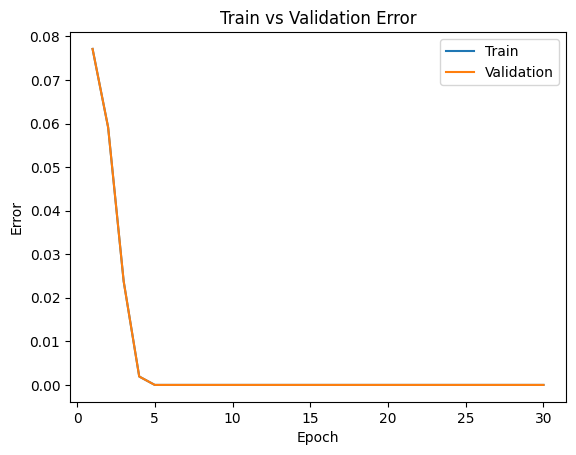

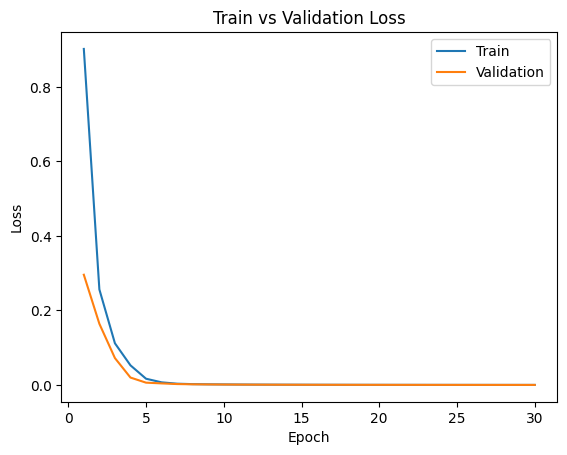

In [38]:
model = TL()
train(model, train_data_alexnet, val_data_alexnet)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [40]:
test_loader = DataLoader(test_data_alexnet)
test_accuracy = get_test_accuracy(model, test_loader)
print(f"The test accuracy is {test_accuracy * 100: .2f}%")

The test accuracy is  100.00%


Answer: Transfer Learning has accuracy rate 100% is much better than 44.85% from before